In [8]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

[]



=== Distribución total de imágenes (Train + Val + Test, Total: 30219) ===
 Emoción  Conteo Total  Proporción (%)
   angry          4953       16.390350
   happy          8989       29.746186
 neutral          6198       20.510275
     sad          6077       20.109865
surprise          4002       13.243324


C:\Users\mcash\AppData\Local\Temp\ipykernel_7000\24742245.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Emoción', y='Conteo Total', data=df, palette='coolwarm')


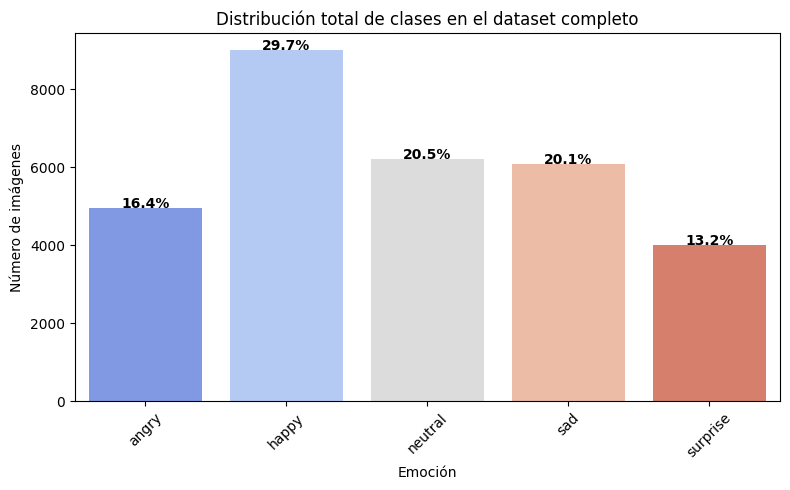

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def total_class_distribution(train_dir, val_dir, test_dir):
    # Listado de carpetas
    datasets = [train_dir, val_dir, test_dir]
    
    # Diccionario para contar imágenes por emoción
    counts = {}
    
    # Recorrer cada dataset
    for folder in datasets:
        for emotion in os.listdir(folder):
            emotion_path = os.path.join(folder, emotion)
            if os.path.isdir(emotion_path):
                counts[emotion] = counts.get(emotion, 0) + len(os.listdir(emotion_path))
    
    # Crear DataFrame
    df = pd.DataFrame({
        'Emoción': list(counts.keys()),
        'Conteo Total': list(counts.values())
    }).sort_values('Emoción')
    
    # Calcular proporción
    total = df['Conteo Total'].sum()
    df['Proporción (%)'] = df['Conteo Total'] / total * 100
    
    # Mostrar tabla
    print(f"\n=== Distribución total de imágenes (Train + Val + Test, Total: {total}) ===")
    print(df.to_string(index=False))
    
    # Gráfico
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x='Emoción', y='Conteo Total', data=df, palette='coolwarm')
    for i, row in df.iterrows():
        ax.text(i, row['Conteo Total'] + 1, f"{row['Proporción (%)']:.1f}%", ha='center', weight='bold')
    plt.title('Distribución total de clases en el dataset completo')
    plt.ylabel('Número de imágenes')
    plt.xlabel('Emoción')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Uso:
total_class_distribution('emotion_dataset/train', 'emotion_dataset/validation', 'emotion_dataset/test')


In [9]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 emociones
])


c:\Users\mcash\anaconda3\envs\VC_MCH_P5_final\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Aumentación de datos para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Solo normalización para validación y test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generadores
train_generator = train_datagen.flow_from_directory(
    'emotion_dataset/train',
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    'emotion_dataset/validation',
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Obtener etiquetas de entrenamiento
y_train = train_generator.classes
classes = np.unique(y_train)

# Calcular pesos
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights))

# Entrenamiento
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    class_weight=class_weights
)


Found 21151 images belonging to 5 classes.
Found 4530 images belonging to 5 classes.
Epoch 1/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.2911 - loss: 1.5655 - val_accuracy: 0.2695 - val_loss: 1.6265
Epoch 2/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.3664 - loss: 1.4175 - val_accuracy: 0.3044 - val_loss: 1.4633
Epoch 3/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.4177 - loss: 1.3377 - val_accuracy: 0.4806 - val_loss: 1.2975
Epoch 4/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.4620 - loss: 1.2707 - val_accuracy: 0.4258 - val_loss: 1.3679
Epoch 5/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.4961 - loss: 1.2190 - val_accuracy: 0.5960 - val_loss: 1.0438
Epoch 6/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.5245 - loss: 1.1733 - val_accuracy: 0.5751 - val_loss: 1.0507
Epoch 7/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.5302 - loss: 1.1513 - val_accuracy: 0.4775 - val_loss: 1.2758
Epoch

In [12]:
# Después de entrenar
model.save('emotion_model.h5')  # formato HDF5
# o
model.save('emotion_model.keras')  # nuevo formato recomendado

Found 4538 images belonging to 5 classes.
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6765 - loss: 0.8371
Precisión en test: 67.65%


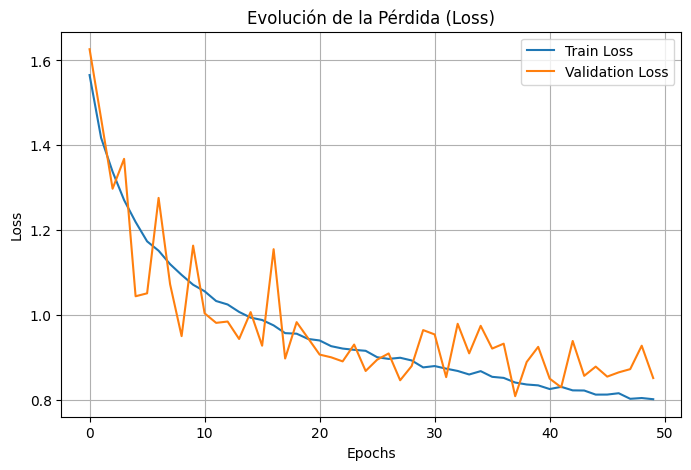

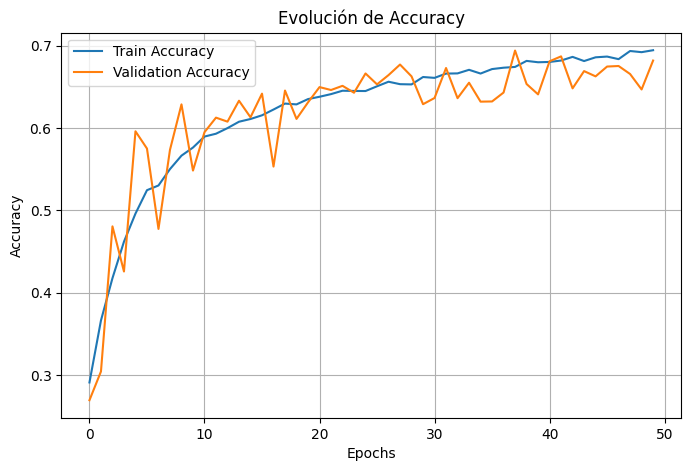

In [14]:
test_generator = val_test_datagen.flow_from_directory(
    'emotion_dataset/test',
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print(f'Precisión en test: {test_acc*100:.2f}%')


# ----- GRÁFICA DE LOSS (train vs validation) -----
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Evolución de la Pérdida (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# ----- GRÁFICA DE ACCURACY (train vs validation) -----
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Evolución de Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Si ya tienes el modelo entrenado, úsalo directamente:
model = load_model('emotion_model_best.h5')

# Lista de etiquetas en orden correcto según tu train_generator
labels = [name for name, idx in sorted(train_generator.class_indices.items(), key=lambda x: x[1])]

# Inicializar cámara
cap = cv2.VideoCapture(0)  # 0 = cámara por defecto

# Cargar detector de rostro Haar Cascade de OpenCV
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

print("Presiona 'q' para salir...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convertir a escala de grises
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detectar rostros
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Extraer la región del rostro
        face_roi = gray[y:y+h, x:x+w]

        # Redimensionar al tamaño que espera el modelo
        face_resized = cv2.resize(face_roi, (48, 48))
        face_normalized = face_resized.astype('float32') / 255.0
        face_input = np.expand_dims(face_normalized, axis=-1)  # añadir canal
        face_input = np.expand_dims(face_input, axis=0)         # añadir batch

        # Predicción
        pred_probs = model.predict(face_input, verbose=0)
        pred_class = np.argmax(pred_probs)
        emotion_label = labels[pred_class]
        confidence = pred_probs[0][pred_class]

        # Dibujar en la ventana
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(frame, f"{emotion_label} ({confidence*100:.1f}%)", 
                    (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)

    # Mostrar la imagen
    cv2.imshow('Detección de Emoción', frame)

    # Salir con 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar recursos
cap.release()
cv2.destroyAllWindows()


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'ruta_a_tu_modelo.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)